In [2]:
import numpy as np
from scipy.integrate import odeint
#from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from array import *
from statistics import mean
from lmfit import minimize, Parameters, Parameter, report_fit
import random

In [3]:
data_file_Vero = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/HSV cell culture kinetics/Projects/Data/Marius Data/Time course AvePA.csv'

Data_Vero = pd.read_csv(data_file_Vero)
print(Data_Vero)
IDs_Vero = Data_Vero.ID.unique()
print(IDs_Vero)

     ID  time     PFU_1     PFU_2     PFU_3      Aver_PFU  log10AvePFU ObsID  \
0  High     6      4100      1800      2200  2.700000e+03     3.431364   Sup   
1  High    12     22500     13000     10000  1.516667e+04     4.180890   Sup   
2  High    24    455000    445000    390000  4.300000e+05     5.633468   Sup   
3  High     6      3450      3600      2850  3.300000e+03     3.518514  Cell   
4  High    12   2200000   1500000   1700000  1.800000e+06     6.255273  Cell   
5  High    24  21500000  14500000  20500000  1.883333e+07     7.274927  Cell   

   MOI  
0    3  
1    3  
2    3  
3    3  
4    3  
5    3  
['High']


In [3]:
def Vir_Dyn_DDD_perI(y,t, betaSup, betaCell, piCell, D, k, deltaI, gamma, K, nk):
    dY = np.zeros(nk+4);
    E = np.zeros(nk)
    S = y[0]
    for i in range(1, nk+1):
        E[i-1] = y[i]
    I = y[nk+1]
    V_Cell = y[nk+2]
    V_Sup = y[nk+3]
    dY[0] = -10**betaSup*V_Sup*S-10**betaCell*V_Cell*S
    dY[1] = 10**betaSup*V_Sup*S+10**betaCell*V_Cell*S - k*E[0]
    for i in range(2, nk+1):
        dY[i] = k*(E[i-2]-E[i-1])
    dY[nk+1] = k*E[nk-1]-deltaI*I
    dY[nk+2] = piCell*I - (D*(V_Cell/I)/(V_Cell/I+10**K))*V_Cell
    dY[nk+3] = (D*(V_Cell/I)/(V_Cell/I+10**K))*V_Cell - gamma*V_Sup
    
    
    return dY

In [4]:
def Vir_Dyn_LinDiff(y,t, piCell, D, k, deltaI, gamma, nk):
    dY = np.zeros(nk+3);
    E = np.zeros(nk)
    for i in range(0, nk):
        E[i] = y[i]
    I = y[nk]
    V_Cell = y[nk+1]
    V_Sup = y[nk+2]
    dY[0] = - k*E[0]
    for i in range(1, nk):
        dY[i] = k*(E[i-1]-E[i])
    dY[nk] = k*E[nk-1]-deltaI*I
    dY[nk+1] = piCell*I - D*V_Cell
    dY[nk+2] = D*V_Cell - gamma*V_Sup
    
    
    return dY

In [5]:
def cost_function(params, tCell, tSup, tMax, V_data, ParamsOrder):
    
    init = params['E1'].value
    for i in range(2,nk+1):
        init = np.append(init, params['E'+str(i)].value)
    init = np.append(init, [params['I'].value, params['VCell'].value, 
                            params['VSup'].value])
    
    parameters = []
    for p in ParamsOrder:
        parameters.append(params[p].value)
    t = np.linspace(0, tMax, 2400)
    
    yCell = odeint(Vir_Dyn_LinDiff, init, t, args=tuple(parameters))

    predicted_Celldata = yCell.T

    ySup = odeint(Vir_Dyn_LinDiff, init, t, args=tuple(parameters))
    predicted_Supdata = ySup.T
    
    indicesCell = [np.where(t>=x)[0][0] for x in tCell]
    indicesSup = [np.where(t>=x)[0][0] for x in tSup]
    
    V_predicted = np.hstack((np.log10(predicted_Celldata[params['nk'].value+1,indicesCell]), 
                             np.log10(predicted_Supdata[params['nk'].value+2,indicesSup])))
    err = (V_predicted - V_data)**2
    
    return err

def Runmodel(params, tMax, dt, ParamsOrder):
    init = params['E1'].value
    for i in range(2,nk+1):
        init = np.append(init, params['E'+str(i)].value)
    init = np.append(init, [params['I'].value, params['VCell'].value, 
                            params['VSup'].value])
    
    parameters = []
    for p in ParamsOrder:
        parameters.append(params[p].value)
    
    t = np.linspace(0, tMax, dt)
    y = odeint(Vir_Dyn_LinDiff, init, t, args=tuple(parameters))
    
    return y.T
    
def setInit(Data, id, nk, C_Tot, VCell0, VSup0):
    
    Init = C_Tot
    for i in range(1,nk):
        Init = np.append(Init, 0)
    Init = np.append(Init, [0.0, VCell0,VSup0])

    return Init

def setInitList(nk):
    InitList = 'E1'
    for i in range(2,nk+1):
        InitList = np.append(InitList, 'E'+ str(i))
        
    InitList = np.append(InitList, ['I', 'VCell', 'VSup'])
    
    return InitList
    



def make_params (nk, InitList, Init, ParamsOrder, ParamsGuess):
    params = Parameters()

    for i in range(0, nk+3):
        if i == nk+1 or i== nk+2:
            params.add(InitList[i], value = Init[i], min =0)
        else:
            params.add(InitList[i], value = Init[i], vary = False)
    for p in range(0, len(ParamsOrder)):
        if 'beta' in ParamsOrder[p] or  ParamsOrder[p]=='K':
            params.add(ParamsOrder[p], value = ParamsGuess[p], vary = False)
        elif  ParamsOrder[p]=='deltaI' or ParamsOrder[p]=='nk' or ParamsOrder[p]=='gamma':
            params.add(ParamsOrder[p], value = ParamsGuess[p], vary = False)
        else:
            params.add(ParamsOrder[p], value = ParamsGuess[p], min = 0)
   
    return params

In [6]:
nk=15
C_Tot = 300000
id = 'High'
ParamsOrder = ['piCell', 'D', 'kappa', 'deltaI', 'gamma', 'nk']
RESULT = []
VCell_data = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].log10AvePFU
VSup_data = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].log10AvePFU
V_data = np.hstack((VCell_data, VSup_data))
tSup = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].time
tCell = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].time
tMax = np.max(Data_Vero.time)
for run in range(1,7):
    print(run)
    ParamsGuess = [random.uniform(10,100), random.uniform(0.001, 0.1), random.uniform(0.8, 1.4), 0.28, 0.04, nk]
    Init = setInit(Data_Vero, id, nk, C_Tot, random.uniform(10,3000), random.uniform(10,3000))
    InitList = setInitList(nk)
    params = make_params (nk, InitList, Init, ParamsOrder, ParamsGuess)  
    result = minimize(cost_function, params, args=(tCell, tSup, tMax, V_data, ParamsOrder))
    RESULT.append(result)

1
2
3
4
5
6


In [7]:
for run in range(0,6):
    print(np.round(RESULT[run].aic,2))

-60.77
-59.14
-60.61
-51.26
-49.44
-15.41


In [8]:
RESULT[0]

/opt/anaconda3/lib/python3.9/site-packages/lmfit/printfuncs.py:322: RuntimeWarning: invalid value encountered in scalar divide
  spercent = f'({abs(par.stderr/par.value):.2%})'


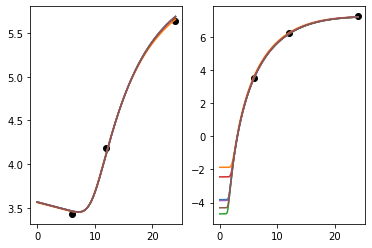

In [9]:
for run in range(0,6):
    y = Runmodel(RESULT[run].params, tMax, 10000, ParamsOrder)
    plt.subplot(1,2,1)
    if run==0:
        plt.plot(tSup, VSup_data, 'o', color = 'k')
    plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+2, :]))
#plt.xlim(5,25)

    plt.subplot(1,2,2)
    if run ==0:
        plt.plot(tCell, VCell_data, 'o', color = 'k')
    plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
#plt.xlim(5,25)

In [10]:
def make_params (nk, InitList, Init, ParamsOrder, ParamsGuess):
    params = Parameters()

    for i in range(0, nk+3):
        if  i== nk+2:
            params.add(InitList[i], value = Init[i], min =0)
        else:
            params.add(InitList[i], value = Init[i], vary = False)
    for p in range(0, len(ParamsOrder)):
        if 'beta' in ParamsOrder[p] or  ParamsOrder[p]=='K':
            params.add(ParamsOrder[p], value = ParamsGuess[p])
        elif  ParamsOrder[p]=='deltaI' or ParamsOrder[p]=='nk' or ParamsOrder[p]=='gamma':
            params.add(ParamsOrder[p], value = ParamsGuess[p], vary = False)
        else:
            params.add(ParamsOrder[p], value = ParamsGuess[p], min = 0)
   
    return params

In [11]:
nk=15
C_Tot = 300000
id = 'High'
ParamsOrder = ['piCell', 'D', 'kappa', 'deltaI', 'gamma', 'nk']
RESULT_VCell0 = []
VCell_data = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].log10AvePFU
VSup_data = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].log10AvePFU
V_data = np.hstack((VCell_data, VSup_data))
tSup = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].time
tCell = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].time
tMax = np.max(Data_Vero.time)
for run in range(1,7):
    ParamsGuess = [random.uniform(10,100), random.uniform(0.001, 0.1), random.uniform(0.8, 1.4), 0.31, 0.04, nk]
    Init = setInit(Data_Vero, id, nk, C_Tot, 0, random.uniform(10,3000))
    InitList = setInitList(nk)
    params = make_params (nk, InitList, Init, ParamsOrder, ParamsGuess)  
    result = minimize(cost_function, params, args=(tCell, tSup, tMax, V_data, ParamsOrder))
    RESULT_VCell0.append(result)

In [12]:
for run in range(0,6):
    print(np.round(RESULT_VCell0[run].aic,2))

-63.29
-63.29
-63.29
-63.29
-63.29
-63.29


In [13]:
RESULT_VCell0[0]

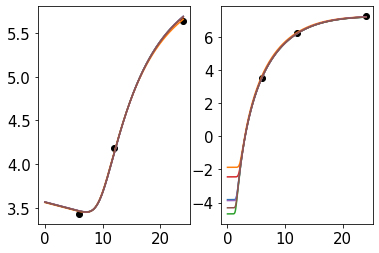

In [15]:
for run in range(0,6):
    y = Runmodel(RESULT[run].params, tMax, 10000, ParamsOrder)
    plt.subplot(1,2,1)
    if run==0:
        plt.plot(tSup, VSup_data, 'o', color = 'k')
    plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+2, :]))
#plt.xlim(5,25)

    plt.subplot(1,2,2)
    if run ==0:
        plt.plot(tCell, VCell_data, 'o', color = 'k')
    plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
#plt.xlim(5,25)

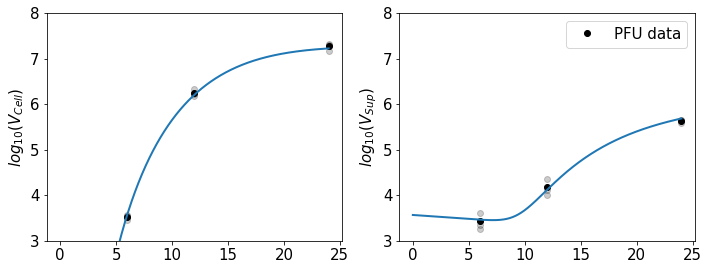

In [17]:
fig = plt.figure(figsize = (10,4))
plt.rcParams.update({'font.size': 15})
N=10000
id = 'High'
t_Celldata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].time
temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].log10AvePFU
y_Cell_1_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].PFU_1
y_Cell_2_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].PFU_2
y_Cell_3_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].PFU_3
y_Celldata = [float(y) for y in temp]
    #print(temp)
t_Supdata = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].time
temp = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].log10AvePFU
y_Sup_1_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].PFU_1
y_Sup_2_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].PFU_2
y_Sup_3_PFU = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].PFU_3
y_Supdata = [float(y) for y in temp]    

t = np.linspace(0, max(Data_Vero.time), N)
plt.subplot(1,2,1)
plt.plot(t_Celldata.values, np.log10(y_Cell_1_PFU),'o', alpha = 0.2,  color = 'black')
plt.plot(t_Celldata.values, np.log10(y_Cell_2_PFU),'o', alpha = 0.2,  color = 'black')
plt.plot(t_Celldata.values, np.log10(y_Cell_3_PFU),'o', alpha = 0.2,  color = 'black')
plt.plot(t_Celldata.values, y_Celldata,'o', color = 'black')

plt.plot(t,np.log10(y[nk+1, :]), linewidth = 2)



plt.ylabel('$log_{10}(V_{Cell})$')
plt.ylim([3, 8])
plt.subplot(1,2,2)
plt.plot(t_Supdata.values, np.log10(y_Sup_1_PFU),'o', alpha = 0.2,  color = 'black')
plt.plot(t_Supdata.values, np.log10(y_Sup_2_PFU),'o', alpha = 0.2,  color = 'black')
plt.plot(t_Supdata.values, np.log10(y_Sup_3_PFU),'o', alpha = 0.2,  color = 'black')
plt.plot(t_Supdata.values, y_Supdata,'o', color = 'black', label = 'PFU data')

plt.plot(t,np.log10(y[nk+2, :]),linewidth = 2)



plt.ylabel('$log_{10}(V_{Sup})$')
        

plt.legend()
plt.ylim([3, 8])
plt.tight_layout()

In [18]:
def make_params (nk, InitList, Init, ParamsOrder, ParamsGuess):
    params = Parameters()

    for i in range(0, nk+3):
        if  i== nk+2:
            params.add(InitList[i], value = Init[i], min =0)
        else:
            params.add(InitList[i], value = Init[i], vary = False)
    for p in range(0, len(ParamsOrder)):
        if 'beta' in ParamsOrder[p] or  ParamsOrder[p]=='K':
            params.add(ParamsOrder[p], value = ParamsGuess[p])
        elif  ParamsOrder[p]=='deltaI' or ParamsOrder[p]=='nk' or ParamsOrder[p]=='gamma' or ParamsOrder[p]=='kappa':
            params.add(ParamsOrder[p], value = ParamsGuess[p], vary = False)
        else:
            params.add(ParamsOrder[p], value = ParamsGuess[p], min = 0)
   
    return params

In [19]:
nk=15
C_Tot = 300000
id = 'High'
ParamsOrder = ['piCell', 'D', 'kappa', 'deltaI', 'gamma', 'nk']
RESULT_VCell0_kappafixed = []
VCell_data = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].log10AvePFU
VSup_data = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].log10AvePFU
V_data = np.hstack((VCell_data, VSup_data))
tSup = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Sup')].time
tCell = Data_Vero[(Data_Vero.ID == id) & (Data_Vero.ObsID == 'Cell')].time
tMax = np.max(Data_Vero.time)
for run in range(1,7):
    ParamsGuess = [random.uniform(10,100), random.uniform(0.001, 0.1), 1.37, 0.29, 0.04, nk]
    Init = setInit(Data_Vero, id, nk, C_Tot, 0, random.uniform(10,3000))
    InitList = setInitList(nk)
    params = make_params (nk, InitList, Init, ParamsOrder, ParamsGuess)  
    result = minimize(cost_function, params, args=(tCell, tSup, tMax, V_data, ParamsOrder))
    RESULT_VCell0_kappafixed.append(result)

In [20]:
for run in range(0,6):
    print(np.round(RESULT_VCell0_kappafixed[run].aic,2))

-10.21
-10.21
-10.21
-10.21
-10.21
-10.21


In [21]:
RESULT_VCell0_kappafixed[1]

/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_4839/2551227775.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_4839/2551227775.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_4839/2551227775.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_4839/2551227775.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
/var/folders/z2/v4k5h92d3x34xw1wf5f8b_nh0000gp/T/ipykernel_4839/2551227775.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
/var/folders/z2/v4k5h92d3

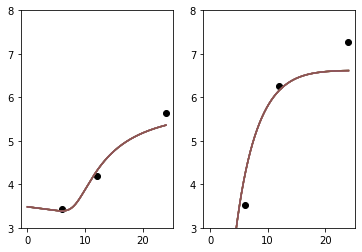

In [23]:
for run in range(0,6):
    y = Runmodel(RESULT_VCell0_kappafixed[run].params, tMax, 10000, ParamsOrder)
    plt.subplot(1,2,1)
    if run==0:
        plt.plot(tSup, VSup_data, 'o', color = 'k')
    plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+2, :]))
    plt.ylim(3,8)

    plt.subplot(1,2,2)
    if run ==0:
        plt.plot(tCell, VCell_data, 'o', color = 'k')
    plt.plot(np.linspace(0,tMax, 10000), np.log10(y[nk+1, :]))
    plt.ylim(3,8)